In [2]:
'''
Naive bayes con feature selection specifica per ogni classe, per ogni classe facciamo
l'estrazione delle features con la tecnica del chi2 e fittiamo i modelli
su ogni classe separatamente 
'''

import time
import codecs
import csv
#import argparse
import os
import numpy as np
import pickle

#from dill import dill
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
#from sklearn import cross_validation, svm
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
from nltk.tokenize import word_tokenize


# modulo per confrontare il risultato delle regex
# richiede entrambi i db già etichettati
import tortellino_parmigiano 
import crea_db


import evaluation_report # stampa confusion_matrix e altro
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
ita_stopwords = set(stopwords.words('italian'))
ita_stemmer = ItalianStemmer()
ita_stemming = ita_stemmer.stem
def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    #doc = map(ita_stemming, doc)
    #doc = [ita_stemmer.stem(a) for a in doc]
    temp = ''
    for par in doc:
        temp = '{} {}'.format(temp, ita_stemming(par))        
    return temp

class CestinoTraining:
    def __init__(self, features, labels, categories):
        self.stemmed = list(map(get_tokenizer, texts))
        self.features = features
        self.labels = np.array(labels)
        self.categories = categories

DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI
# ci assicuriamo siano presenti i DB
training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) ################################

    
if os.path.exists('/home/backup/dati_e_csv/training_stemmed-bubu.pickle'):
    print('Trovato salvataggio training set')
    with open('/home/backup/dati_e_csv/training_stemmed-bubu.pickle', 'rb') as file:
        salvataggio = pickle.load(file)
    texts = salvataggio.features
    stemmed_train = salvataggio.stemmed
    Y = salvataggio.labels
    etichette = ['attivazione', 'canone rai', 'cessazione', 'contratto', 'credito',
                 'domiciliazione', 'fatturazione', 'gr-invito a chiamare - focus', 'non di competenza', 'richiamate']
    print('Salvataggio caricato')
else:
    print('Creo il training set')
    
    texts = list()
    labels = list()
    names= []

    # load training dataset # possiamo usare sqlite
    with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
        reader = csv.reader(file, delimiter=';')
        etichette = next(reader)
        for row in reader:
            # load documents
            #print('Nome {}, etichette {}, conversazione{}'.format(row[10], row[:10], row[11]+row[12]))
            #raise SystemExit
            #row[11] + row[12])
            unito = (row[11] + row[12]).replace('#O:', '').replace('#C:', '') #concatena il testo cliente con operatore
            texts.append(unito)
            # load row name
            names.append(row[10])
            # load labels
            labels.append(list(map(lambda x: int(x), row[:10])))

    print('dimensioni:',len(texts), len(labels))
    # tokenization function # possiamo usare anche solo un canale cliente/operatore
    print('Inizio lo stemming')

    salvataggio = CestinoTraining(texts, labels, etichette)
    stemmed_train = salvataggio.stemmed
    Y = salvataggio.labels
    with open('/home/backup/dati_e_csv/training_stemmed-bubu.pickle', 'wb') as file:
        pickle.dump(salvataggio, file, protocol=0)
    print('Training set creato e salvato')

# ------------------------------------

# DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI


# # ci assicuriamo siano presenti i DB
# training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
# test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) 

# texts = list()
# labels = list()
# names= []
# names_and_text = []

# # load training dataset # possiamo usare sqlite
# start_time = time.time()
# with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
#     reader = csv.reader(file, delimiter=';')
#     etichette = next(reader)
#     for row in reader:
#         # load documents
#         #print('Nome {}, etichette {}, conversazione{}'.format(row[10], row[:10], row[11]+row[12]))
#         #raise SystemExit
#         unito = row[11]+row[12].replace('#O:', '').replace('#C:', '') #concatena il testo cliente con operatore
#         texts.append(unito) 
#         # load row name
#         names.append(row[10])
#         # load labels
#         labels.append(list(map(lambda x: int(x), row[:10])))
#         names_and_text.append(tuple([row[10]]) + tuple([unito]) + tuple([row[:10]]))
# Y = np.array(labels)
# print(len(texts), len(labels))
# # tokenization function # possiamo usare anche solo un canale cliente/operatore

# ita_stopwords = set(stopwords.words('italian'))
# ita_stemmer = ItalianStemmer()
# ita_stemming = ita_stemmer.stem

# def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
#     doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
#     #doc = map(ita_stemming, doc)
#     #doc = [ita_stemmer.stem(a) for a in doc]
#     temp = ''
#     for par in doc:
#         temp = '{} {}'.format(temp, ita_stemming(par))
#     return temp

# stemmed_train = list(map(get_tokenizer, texts))
#print('Stemmati in -- %s seconds ----!'% (time.time() - start_time))


Training sqlite e csv presenti!
Carico training_regex.csv
Test sqlite e csv presenti!
Carico test_manina
Trovato salvataggio training set
Salvataggio caricato


In [ ]:
# GridSearch for tuning countvect parameters --> using a subset of all data due to Hardware resource
pipeline = Pipeline([
        ('vect': CountVectorizer()),
        ('tfidf': TfidfTransformer()),
    ])
parameters = {'vect__ngram_range': ((1, 1),(1, 2),(1,3)),
              'vect__max_df': (0.5,0.75,1.0),
              'vect__min_df': (0,0.25,0.4),
              'vect__max_features': (None,50,500,1000, 5000),
              'tfidf__use_idf': (True,False),
              'tfidf__smooth_idf': (True,False),
              #'clf__estimator__alpha': (1.0,10.0,50.0,100.0),
              #'clf__estimator__fit_prior': (True, False),
              #'clf__estimator__penalty': ('l1','l2')
             } 

gs = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, verbose=10)
print('grid search in action...')
start_time = time.time()
gs.fit(stemmed_train[:5000], Y)

print('\n PARAMETRI STIMATI in -- %s ---. Algoritmo pronto per essere fittato' % (time.time() - start_time))
print('BEST f1-macro SCORE: %0.3f' % gs.best_score_)
print('BEST PARAMETRS SET:',gs.best_score_)     
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
     print('\t%s: %r' % (param_name, best_parameters[param_name]))
print('\n --- TO-DO: fill Countvect with above parameters and run to rebuild data matrix.' )

In [11]:
# selecting TS subset due to computational resource limitation
stemmed_train = stemmed_train[:15000]
Y = Y[:15000]


# Build data matrix for training set: stemmed,stopword
print('building DT matrix...')
start_time = time.time()
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(stemmed_train)
#tf_transformer = TfidfTransformer(use_idf=True)
#X_train_counts = tf_transformer.fit_transform(X_train_counts)
print('DT matrix ceated in -- {}s ---.shape: {}, {}'.format(
        time.time() - start_time, X_train_counts.shape[0],X_train_counts.shape[1]))

# creo training, validation e test per fare le valutazioni del modello sulle regex
print('splitting data in 3 folds...')
start_time = time.time()
train, test, y_train, y_test = train_test_split(X_train_counts, Y, test_size=0.4, random_state=0)
print('splitted in -- %ss---'%(time.time() - start_time))

print('\nDATA DIMENSION:\n\t \n\ttrain:\t {}\n \ttest:\t {}'.format(train.shape, test.shape))

building DT matrix...
DT matrix ceated in -- 3.186915397644043s ---.shape: 15000, 25875
splitting data in 3 folds...
splitted in -- 0.027646303176879883s---

DATA DIMENSION:
	 
	train:	 (9000, 25875)
 	test:	 (6000, 25875)


In [33]:
X_train_counts.todense

<15000x25875 sparse matrix of type '<class 'numpy.int64'>'
	with 1380811 stored elements in Compressed Sparse Row format>

In [4]:
# learn the model for testing on regex
start_time = time.time()
algo = OneVsRestClassifier(MultinomialNB())
regex_model = algo.fit(train,y_train)
print('models fitted in -- %ss ---'%(time.time() - start_time))

models fitted in -- 0.18243169784545898s ---


In [5]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
for i,model in enumerate(regex_model.estimators_):
    regex_predictions = model.predict(test)
    printmd('**{}**'.format(etichette[i]))
    print(classification_report(y_test[:,i], regex_predictions))
    print(confusion_matrix(y_test[:,i], regex_predictions))
    



**attivazione**

             precision    recall  f1-score   support

          0       0.95      0.82      0.88      5450
          1       0.24      0.58      0.34       550

avg / total       0.89      0.79      0.83      6000

[[4448 1002]
 [ 232  318]]


**canone rai**

             precision    recall  f1-score   support

          0       0.98      0.90      0.94      5749
          1       0.21      0.57      0.31       251

avg / total       0.95      0.89      0.91      6000

[[5201  548]
 [ 107  144]]


**cessazione**

             precision    recall  f1-score   support

          0       0.98      0.93      0.96      5861
          1       0.12      0.37      0.18       139

avg / total       0.96      0.92      0.94      6000

[[5464  397]
 [  87   52]]


**contratto**

             precision    recall  f1-score   support

          0       0.92      0.84      0.88      5141
          1       0.36      0.53      0.43       859

avg / total       0.84      0.80      0.81      6000

[[4339  802]
 [ 403  456]]


**credito**

             precision    recall  f1-score   support

          0       0.72      0.81      0.76      3086
          1       0.77      0.66      0.71      2914

avg / total       0.74      0.74      0.74      6000

[[2493  593]
 [ 983 1931]]


**domiciliazione**

             precision    recall  f1-score   support

          0       0.97      0.90      0.94      5798
          1       0.10      0.33      0.16       202

avg / total       0.95      0.88      0.91      6000

[[5223  575]
 [ 135   67]]


**fatturazione**

             precision    recall  f1-score   support

          0       0.87      0.84      0.86      4801
          1       0.44      0.49      0.46      1199

avg / total       0.78      0.77      0.78      6000

[[4047  754]
 [ 611  588]]


**gr-invito a chiamare - focus**

             precision    recall  f1-score   support

          0       0.74      0.75      0.74      3250
          1       0.70      0.68      0.69      2750

avg / total       0.72      0.72      0.72      6000

[[2446  804]
 [ 874 1876]]


**non di competenza**

             precision    recall  f1-score   support

          0       0.98      0.92      0.95      5767
          1       0.23      0.61      0.33       233

avg / total       0.95      0.90      0.92      6000

[[5288  479]
 [  92  141]]


**richiamate**

             precision    recall  f1-score   support

          0       0.93      0.87      0.90      5404
          1       0.25      0.39      0.30       596

avg / total       0.86      0.82      0.84      6000

[[4697  707]
 [ 363  233]]


In [5]:
# predizioni sul training set 
regex_predictions = regex_model.predict(test)
print('PREDICTION sul training con alpha=%s' % 1.0)
print(classification_report(y_test, regex_predictions, target_names=etichette))

print('\n','INDICI: \n')
print('accuracy', accuracy_score(y_test, regex_predictions))
print('precision micro',precision_score(y_test,regex_predictions, average='micro') )
print('recall micro',recall_score(y_test, regex_predictions, average='micro'))
print('f1 micro', f1_score(y_test, regex_predictions, average='micro'))
print('precision macro', precision_score(y_test, regex_predictions, average='macro') )
print('recall macro', recall_score(y_test,regex_predictions, average='macro'))
print('f1 macro', f1_score(y_test, regex_predictions, average='macro'))

# print error rate for each category
print('\n ERROR RATES\n')
for cat in range(Y.shape[1]):
    print('error-rate for %s: ' % etichette[cat], 1 - accuracy_score(y_test[:,cat], regex_predictions[:,cat]))
    
#prior = np.array[[0.4,0.6],[],[],[],[],[],[],[],[],[]]

PREDICTION sul training con alpha=1.0
                              precision    recall  f1-score   support

                 attivazione       0.24      0.58      0.34       550
                  canone rai       0.21      0.57      0.31       251
                  cessazione       0.12      0.37      0.18       139
                   contratto       0.36      0.53      0.43       859
                     credito       0.77      0.66      0.71      2914
              domiciliazione       0.10      0.33      0.16       202
                fatturazione       0.44      0.49      0.46      1199
gr-invito a chiamare - focus       0.70      0.68      0.69      2750
           non di competenza       0.23      0.61      0.33       233
                  richiamate       0.25      0.39      0.30       596

                 avg / total       0.56      0.60      0.56      9693


 INDICI: 

accuracy 0.225166666667
precision micro 0.465709473009
recall micro 0.598988961106
f1 micro 0.524007220217


In [ ]:
# importo e trasformo il test set annotato a mano
unito_test = []
names_test = []
test_texts = list()
y_true_ammano = list()

# load test data
# carica il test set
with codecs.open(os.path.join(DATA_FOLDER, test_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)
    print(etichette)
    for row in reader:
        # 
        test_texts.append((row[1] + row[2]).replace('O:', '').replace('C:', ''))# 
        # load names
        names_test.append(row[0])
        # load labels
        y_true_ammano.append(list(map(lambda x: int(x),row[-10:])))
        
stemmed_test = list(map(get_tokenizer, test_texts))
print('\ntest set caricato')

# test set vectorization
test_ammano = count_vect.transform(stemmed_test)
print('\nTest set vettorizzato. pronti')

# prendo dal training solo i documenti che sono nel test_set
# subset_X_train = []
# y_true_train = []
# for name,text,label in names_and_text:
#     if name in names_test:
#         subset_X_train.append(text)
#         y_true_train.append(label)

# stemmed_subset_train = list(map(get_tokenizer, subset_X_train))
# subset_X_train_DTM = count_vect.transform(stemmed_subset_train)

['attivazione', 'canone rai', 'cessazione', 'contratto', 'credito', 'domiciliazione', 'fatturazione', 'gr-invito a chiamare - focus', 'non di competenza', 'richiamate']


In [12]:
for i,model in enumerate(regex_model.estimators_):
    regex_predictions2 = model.predict(test_ammano)
    printmd('**{}**'.format(etichette[i]))
    print(classification_report(np.array(y_true_ammano)[:,i], regex_predictions2))
    print(confusion_matrix(np.array(y_true_ammano)[:,i], regex_predictions2))

**attivazione**

             precision    recall  f1-score   support

          0       0.95      0.87      0.91       351
          1       0.56      0.78      0.65        73

avg / total       0.88      0.86      0.86       424

[[306  45]
 [ 16  57]]


**canone rai**

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       361
          1       0.85      0.52      0.65        63

avg / total       0.91      0.92      0.91       424

[[355   6]
 [ 30  33]]


**cessazione**

             precision    recall  f1-score   support

          0       0.98      0.93      0.96       414
          1       0.12      0.40      0.19        10

avg / total       0.96      0.92      0.94       424

[[386  28]
 [  6   4]]


**contratto**

             precision    recall  f1-score   support

          0       0.93      0.83      0.88       350
          1       0.47      0.69      0.56        74

avg / total       0.85      0.81      0.82       424

[[292  58]
 [ 23  51]]


**credito**

             precision    recall  f1-score   support

          0       0.85      0.69      0.76       262
          1       0.62      0.81      0.70       162

avg / total       0.76      0.74      0.74       424

[[181  81]
 [ 31 131]]


**domiciliazione**

             precision    recall  f1-score   support

          0       0.99      0.89      0.94       403
          1       0.27      0.76      0.40        21

avg / total       0.95      0.89      0.91       424

[[360  43]
 [  5  16]]


**fatturazione**

             precision    recall  f1-score   support

          0       0.77      0.82      0.79       300
          1       0.48      0.40      0.43       124

avg / total       0.68      0.70      0.69       424

[[246  54]
 [ 75  49]]


**gr-invito a chiamare - focus**

             precision    recall  f1-score   support

          0       0.97      0.48      0.64       401
          1       0.08      0.78      0.14        23

avg / total       0.93      0.50      0.62       424

[[192 209]
 [  5  18]]


**non di competenza**

             precision    recall  f1-score   support

          0       0.92      0.97      0.94       374
          1       0.59      0.34      0.43        50

avg / total       0.88      0.89      0.88       424

[[362  12]
 [ 33  17]]


**richiamate**

             precision    recall  f1-score   support

          0       1.00      0.80      0.89       421
          1       0.02      0.67      0.05         3

avg / total       0.99      0.80      0.88       424

[[338  83]
 [  1   2]]


In [7]:
# predico sul test set e sul training set per controllare overfitting
y_pred = regex_model.predict(test_ammano)
#y_pred_train = main_clf.predict(X_train_counts)
y_true_ammano = np.array(y_true_ammano)
print('REPORT SENZA FEATURE SELECTION sul test set:')
print(classification_report(y_true_ammano, y_pred, target_names=etichette))

# accuracy_test = []
# accuracy_train = []
# for i in range(y_pred.shape[1]):
#     accuracy_test.append(accuracy_score(y_true[:,i], y_pred[:,i]))
#     accuracy_train.append(accuracy_score(Y[:,i], y_pred_train[:,i]))
    

# print ('ERROR RATE PER CLASSE:')
# print('{:>35} {:>10}'.format('test','train'))
# for n in range(len(etichette[:10])):
#       print('{:>23}{:>12}{:>10}'.format(etichette[n],round(1-accuracy_test[n],3),round(1-accuracy_train[n],3)))
    
# print('''
#     COME INTERPRETARE ERROR RATE:
    
#     Training error is low but is much lower than testing error - overfitting
#     Both errors are low - ok
#     Both errors are high - underfitting
#     Training error is high but testing is low - error in implementation or very small dataset
# ''')

print('\n','INDICI: \n')
print('accuracy', accuracy_score(y_true_ammano, y_pred))
print('precision micro',precision_score(y_true_ammano, y_pred, average='micro') )
print('recall micro',recall_score(y_true_ammano, y_pred, average='micro'))
print('f1 micro', f1_score(y_true_ammano, y_pred, average='micro'))
print('precision macro', precision_score(y_true_ammano, y_pred, average='macro') )
print('recall macro', recall_score(y_true_ammano, y_pred, average='macro'))
print('f1 macro', f1_score(y_true_ammano, y_pred, average='macro'))

# print error rate for each category
print('\n ERROR RATES\n')
for cat in range(Y.shape[1]):
    print('error-rate for %s: ' % etichette[cat], 1 - accuracy_score(y_true_ammano[:,cat], y_pred[:,cat]))

REPORT SENZA FEATURE SELECTION sul test set:
                              precision    recall  f1-score   support

                 attivazione       0.55      0.70      0.61        73
                  canone rai       0.71      0.43      0.53        63
                  cessazione       0.13      0.40      0.20        10
                   contratto       0.46      0.57      0.51        74
                     credito       0.62      0.81      0.71       162
              domiciliazione       0.21      0.62      0.31        21
                fatturazione       0.48      0.35      0.41       124
gr-invito a chiamare - focus       0.10      0.87      0.18        23
           non di competenza       0.53      0.34      0.41        50
                  richiamate       0.03      0.67      0.06         3

                 avg / total       0.52      0.58      0.52       603


 INDICI: 

accuracy 0.122641509434
precision micro 0.383025027203
recall micro 0.583747927032
f1 micro 0.462549

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier

def pari(i):
    if i%2 == 0:
        return 0
    else:
        return 1

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), i=0):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

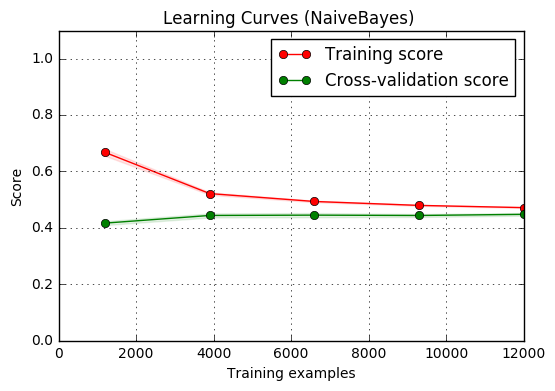

In [17]:
estimators = regex_model
#svm_all = VotingClassifier(estimators)
#fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25,50))

#print(matrix_countvect.shape)
#print(etichette_train_set.shape)
#for i in range(Y.shape[1]):
title = "Learning Curves (NaiveBayes) " #+ etichette[i]
plot_learning_curve(estimators, title, X_train_counts, Y, (0, 1.1), cv=5, n_jobs=1)
plt.show()

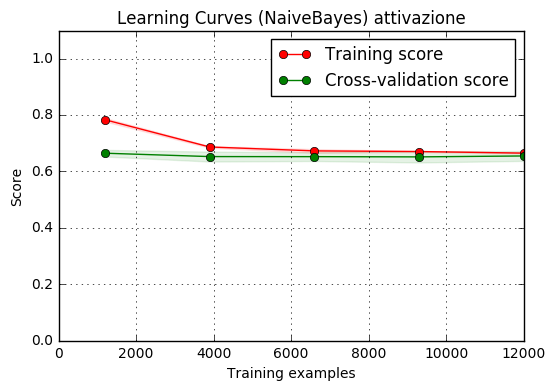

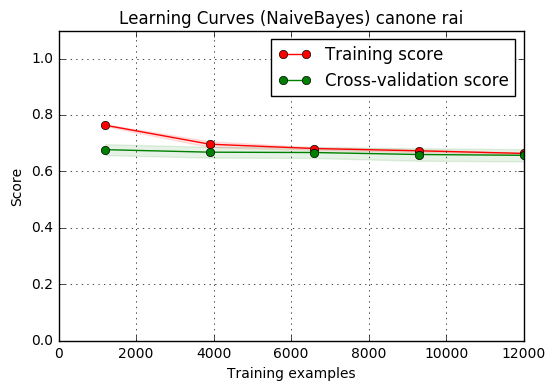

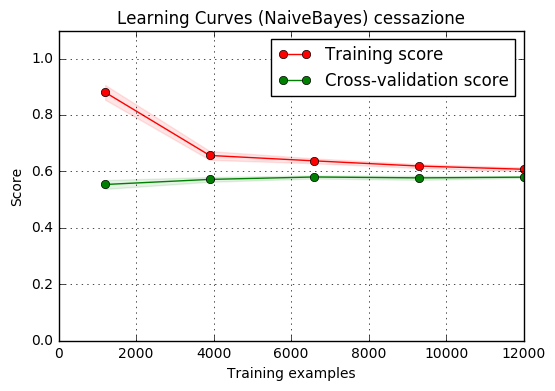

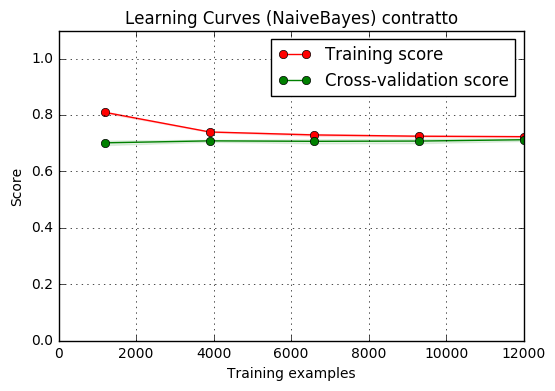

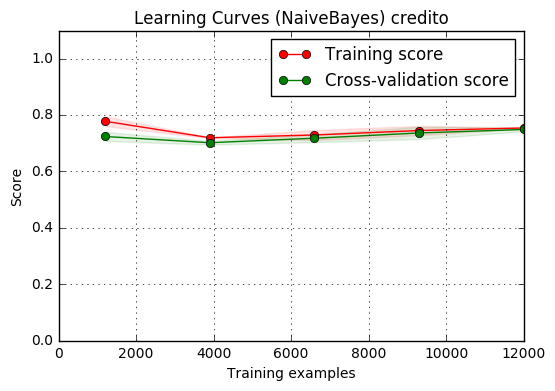

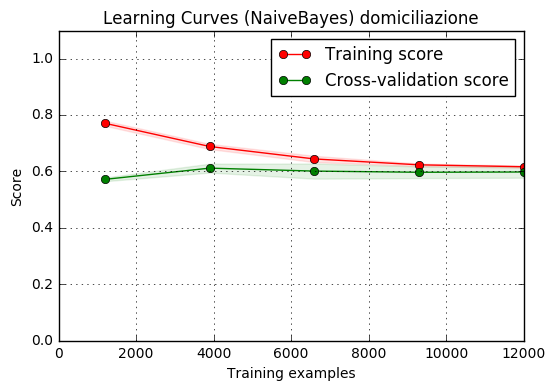

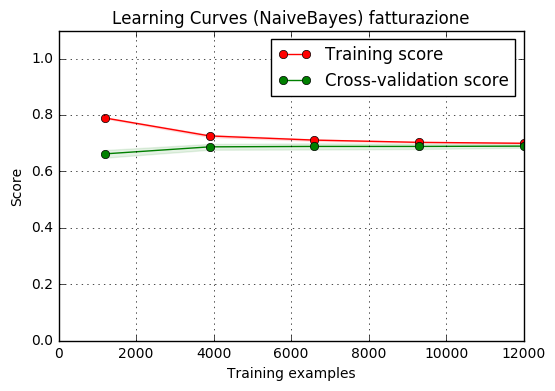

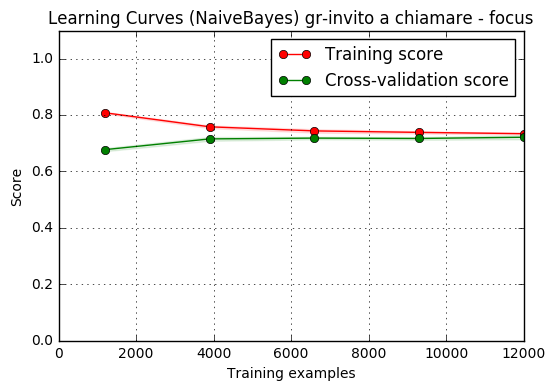

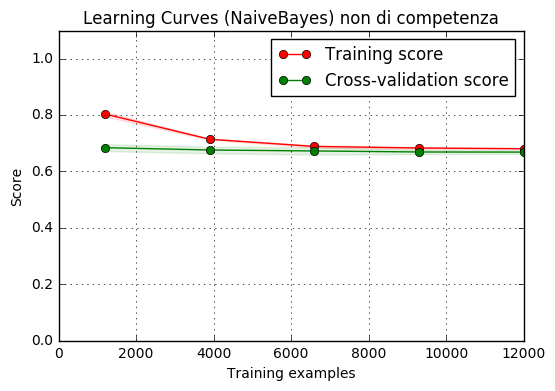

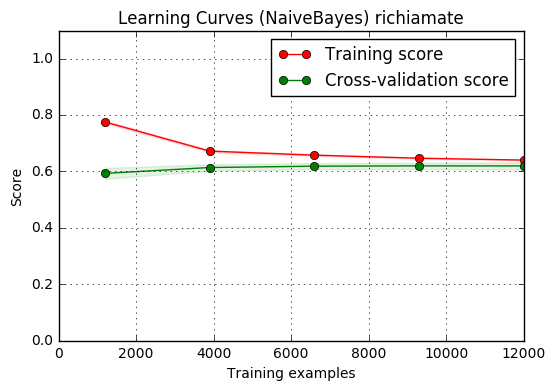

In [18]:
for i in range(Y.shape[1]):
    title = "Learning Curves (NaiveBayes) " + etichette[i]
    plot_learning_curve(estimators, title, X_train_counts, Y[:,i], (0, 1.1), cv=5, n_jobs=1)
plt.show()

In [ ]:
# esploriamo le features che selezione il modell